## Predict Product Prices

### Week 7 Day 2

Selecting our model and evaluating the base model against the task.

Keep in mind: our base model has 8 billion params, quantized down to 4 bits
Compared with GPT-4o at TRILLIONS of params!

# IMPORTANT please read me!!

When you run the pip installs below, you may get an error from pip complaining about an incompatible version of fsspec.

You should ignore that error! The version of fsspec is the right version, needed by HuggingFace.

If you ask ChatGPT, it will encourage you to pip install a more recent version of fsspec. But that would be problematic; HuggingFace will fail to load the dataset later with an obscure error about file systems.

So please run the pip installs as they appear below, and look the other way if you get an error!


In [ ]:
# pip installs - ignore the error message!

# !pip install -q datasets requests torch peft bitsandbytes transformers trl accelerate sentencepiece tiktoken matplotlib

In [1]:
# imports

import os
import re
import math
from tqdm import tqdm
# from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Tokenizers

LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"
QWEN_2_5 = "Qwen/Qwen2.5-7B"
GEMMA_2 = "google/gemma-2-9b"
PHI_3 = "microsoft/Phi-3-medium-4k-instruct"

# Constants

BASE_MODEL = LLAMA_3_1
HF_USER = "lubhu"
DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

### Log in to HuggingFace

If you don't already have a HuggingFace account, visit https://huggingface.co to sign up and create a token.

Then select the Secrets for this Notebook by clicking on the key icon in the left, and add a new secret called `HF_TOKEN` with the value as your token.

In [3]:
# Log in to HuggingFace
from dotenv import load_dotenv

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
def investigate_tokenizer(model_name):
  print("Investigating tokenizer for", model_name)
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  for number in [0, 1, 10, 100, 999, 1000]:
    tokens = tokenizer.encode(str(number), add_special_tokens=False)
    print(f"The tokens for {number}: {tokens}")

In [5]:
# Now we will try this with each model: LLAMA_3_1, QWEN_2_5, GEMMA_2, PHI_3

investigate_tokenizer(LLAMA_3_1)

Investigating tokenizer for meta-llama/Meta-Llama-3.1-8B
The tokens for 0: [15]
The tokens for 1: [16]
The tokens for 10: [605]
The tokens for 100: [1041]
The tokens for 999: [5500]
The tokens for 1000: [1041, 15]


# Load our data

We uploaded it to Hugging Face, so it's easy to retrieve it now

In [6]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [7]:
print(train[0])

{'text': 'How much does this cost to the nearest dollar?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7\n\nPrice is $227.00', 'price': 226.95}


# Prepare our Base Llama Model for evaluation

Load our base model with 4 bit quantization and try out 1 example

In [8]:
## pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [9]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5.6 GB


In [17]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      # print(f"Contents: {contents}")
      contents = contents.replace(',','').replace('$','')
      # print(f"Contents after replace: {contents}")
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [18]:
extract_price("Price is $999999999.999999 blah blah, so cheap")

999999999.999999

In [20]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [21]:
print(test[0]['text'])

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


In [22]:
model_predict(test[0]['text'])

1800.0

# Evaluation!

Trying out our base Llama 3.1 model against the Test dataset

In [23]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $1,800.00 Truth: $374.41 Error: $1,425.59 SLE: 2.46 Item: OEM AC Compressor w/...
2: Guess: $25.00 Truth: $225.11 Error: $200.11 SLE: 4.68 Item: Motorcraft YB3125 Fa...
3: Guess: $25.00 Truth: $61.68 Error: $36.68 SLE: 0.77 Item: Dorman Front Washer ...
4: Guess: $1,999.00 Truth: $599.99 Error: $1,399.01 SLE: 1.45 Item: HP Premium HD Plus T...
5: Guess: $7.50 Truth: $16.99 Error: $9.49 SLE: 0.56 Item: Super Switch Pickup ...
6: Guess: $1.00 Truth: $31.99 Error: $30.99 SLE: 7.86 Item: Horror Bookmarks, Re...
7: Guess: $89.99 Truth: $101.79 Error: $11.80 SLE: 0.01 Item: SK6241 - Stinger 4 G...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Lig...
9: Guess: $299.00 Truth: $635.86 Error: $336.86 SLE: 0.57 Item: Randall G3 Plus Comb...
10: Guess: $25.99 Truth: $65.99 Error: $40.00 SLE: 0.83 Item: HOLDWILL 6 Pack LED ...
11: Guess: $110.00 Truth: $254.21 Error: $144.21 SLE: 0.69 Item: Viking Horns 3 Gallo...
12: Guess: $1,800.00 Truth: $412.99 Error

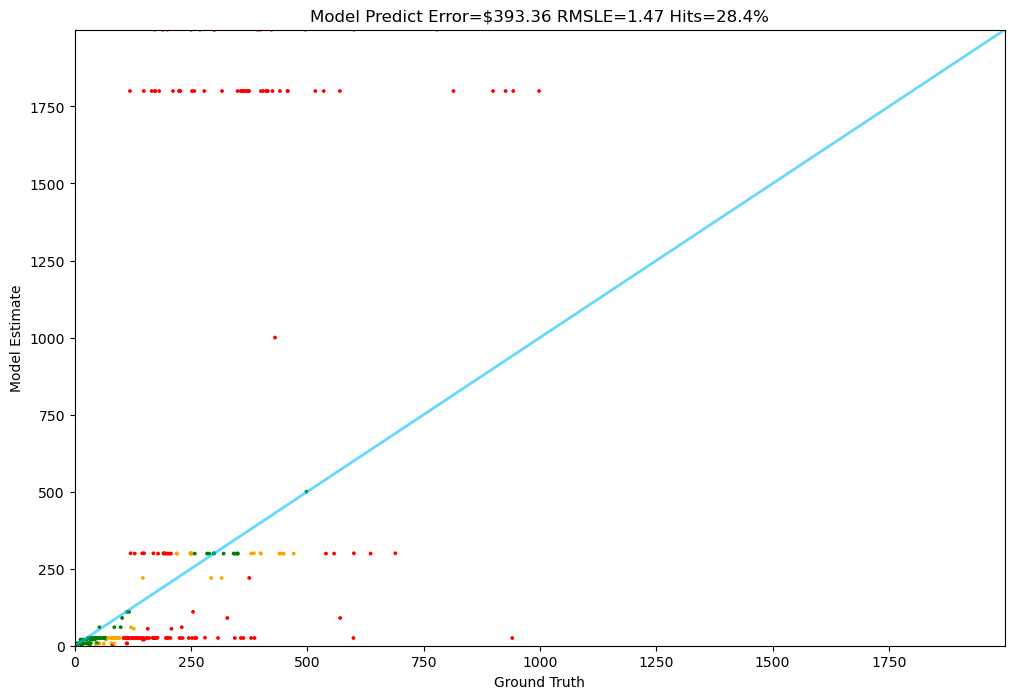

In [24]:
Tester.test(model_predict, test)